# 0.) Import the Credit Card Fraud Data From CCLE

In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

In [2]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/fraudTest.csv")

In [4]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# 1.) Use scikit learn preprocessing to split the data into 70/30 in out of sample

In [5]:
data=df[["trans_date_trans_time","amt","gender","city_pop","is_fraud"]]

In [6]:
data['time_var'] = pd.DatetimeIndex(data["trans_date_trans_time"]).hour

<ipython-input-6-bb6feace62fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_var'] = pd.DatetimeIndex(data["trans_date_trans_time"]).hour


In [7]:
data.drop(columns=["trans_date_trans_time"])
dummies=pd.get_dummies(data["gender"])
X=pd.concat([dummies,data[["amt","city_pop","time_var"]]],axis=1)
y=data["is_fraud"]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# 2.) Make three sets of training data (Oversample, Undersample and SMOTE)

In [9]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Oversample
ros=RandomOverSampler(random_state=0)
ros.fit(X_train,y_train)
X_resampled1,y_resampled1=ros.fit_resample(X_train,y_train)

In [10]:
#Undersample
rus=RandomUnderSampler(random_state=0)
rus.fit(X_train,y_train)
X_resampled2,y_resampled2=rus.fit_resample(X_train,y_train)

In [11]:
#SMOTE
oversample=SMOTE()
X_resampled3,y_resampled3=oversample.fit_resample(X_train,y_train)

# 3.) Train three logistic regression models 

In [12]:
from sklearn.linear_model import LogisticRegression
#Oversample
clf = LogisticRegression()
log_reg1=clf.fit(X_resampled1, y_resampled1)
y_pred_over=clf.predict(X_test)

In [13]:
#Undersample
log_reg2=clf.fit(X_resampled2, y_resampled2)
y_pred_under=clf.predict(X_test)

In [14]:
#SMOTE
log_reg3=clf.fit(X_resampled3,y_resampled3)
y_pred_smote=clf.predict(X_test)

# 4.) Test the three models

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [16]:
#Oversample
cm = confusion_matrix(y_test, y_pred_over)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
accuracy = accuracy_score(y_test, y_pred_over)

print("Sensitivity: {:.2f}".format(sensitivity))
print("Specificity: {:.2f}".format(specificity))
print("Accuracy: {:.2f}".format(accuracy))


print(cm)

Sensitivity: 0.76
Specificity: 0.81
Accuracy: 0.81
[[134075  32001]
 [   151    489]]


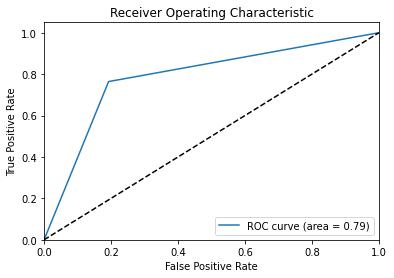

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_over)
auc = roc_auc_score(y_test, y_pred_over)

plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
#Under
cm = confusion_matrix(y_test, y_pred_under)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
accuracy = accuracy_score(y_test, y_pred_under)

print("Sensitivity: {:.2f}".format(sensitivity))
print("Specificity: {:.2f}".format(specificity))
print("Accuracy: {:.2f}".format(accuracy))


print(cm)

Sensitivity: 0.77
Specificity: 0.81
Accuracy: 0.81
[[133955  32121]
 [   150    490]]


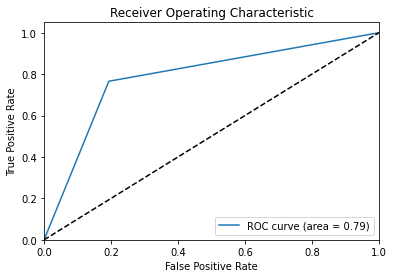

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_under)
auc = roc_auc_score(y_test, y_pred_under)

plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
#SMOTE

cm = confusion_matrix(y_test, y_pred_smote)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
accuracy = accuracy_score(y_test, y_pred_smote)

print("Sensitivity: {:.2f}".format(sensitivity))
print("Specificity: {:.2f}".format(specificity))
print("Accuracy: {:.2f}".format(accuracy))


print(cm)

Sensitivity: 0.76
Specificity: 0.82
Accuracy: 0.82
[[135977  30099]
 [   153    487]]


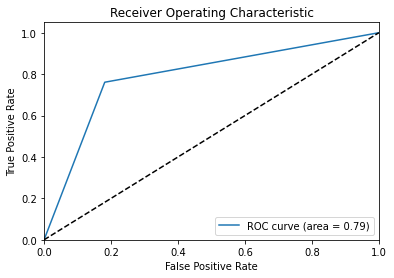

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_smote)
auc = roc_auc_score(y_test, y_pred_smote)

plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 5.) Which performed best in Out of Sample metrics?

SMOTE performs best since it has the largest accuracy score.

# 6.) Pick two features and plot the two classes before and after SMOTE.

In [22]:
#Before
raw_temp=pd.concat([X_train,y_train],axis=1)

In [23]:
raw_temp[raw_temp["is_fraud"]==1]["amt"]
raw_temp[raw_temp["is_fraud"]==1]["city_pop"]

18537      67082
217750       722
125550      6841
277932      2693
91979     841711
           ...  
109575      2304
58596        142
36187       3766
372370      1532
355612     21125
Name: city_pop, Length: 1505, dtype: int64

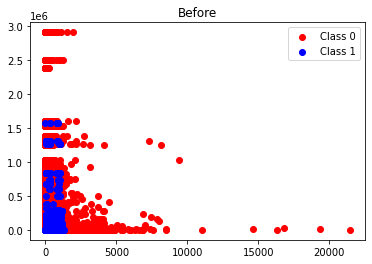

In [24]:
plt.scatter(raw_temp[raw_temp["is_fraud"]==0]["amt"],raw_temp[raw_temp["is_fraud"]==0]["city_pop"],color="red",label="Class 0")
plt.scatter(raw_temp[raw_temp["is_fraud"]==1]["amt"],raw_temp[raw_temp["is_fraud"]==1]["city_pop"],color="blue",label="Class 1")

plt.legend()
plt.title("Before")
plt.show()

In [25]:
#After
new_temp=pd.concat([X_resampled3,y_resampled3],axis=1)

In [26]:
new_temp[new_temp["is_fraud"]==1]["amt"]
new_temp[new_temp["is_fraud"]==1]["city_pop"]

255        67082
707          722
1228        6841
1291        2693
1494      841711
           ...  
774991    272134
774992      1470
774993      1515
774994      1228
774995       870
Name: city_pop, Length: 387498, dtype: int64

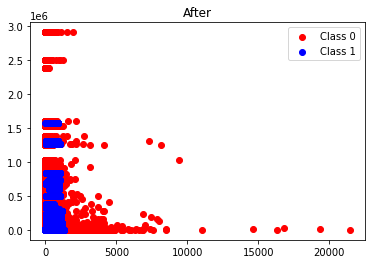

In [27]:
plt.scatter(new_temp[new_temp["is_fraud"]==0]["amt"],new_temp[new_temp["is_fraud"]==0]["city_pop"],color="red",label="Class 0")
plt.scatter(new_temp[new_temp["is_fraud"]==1]["amt"],new_temp[new_temp["is_fraud"]==1]["city_pop"],color="blue",label="Class 1")

plt.legend()
plt.title("After")
plt.show()